In [1]:
# !pip install bertopic
# !pip install sentence-transformers
# !pip install wordcloud
# !pip install transformers

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import gc  # Garbage collector for memory management
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Check GPU availability and configuration
print("Checking GPU availability...")
if torch.cuda.is_available():
    print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    # Set default tensor type to cuda for better performance
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda")
else:
    print("❌ GPU not available, using CPU instead")
    device = torch.device("cpu")

# Function for memory management
def clear_gpu_memory():
    """Clear GPU memory cache to prevent out-of-memory errors"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("GPU memory cleared")

Checking GPU availability...
✅ GPU is available: Tesla T4
Total GPU Memory: 15.83 GB


In [5]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
# Set up colors and style for visualizations
plt.style.use('fivethirtyeight')
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

print("Setup complete! Let's start analyzing product reviews.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Setup complete! Let's start analyzing product reviews.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [43]:
# https://nijianmo.github.io/amazon/index.html
file_path = "Digital_Music_5.json"

In [44]:
# Create a function to load the data
def load_amazon_data(file_path):
    """
    Load Amazon review data from a JSON file and return a sample.

    """
    try:
        df = pd.read_json(file_path, lines=True)


        return df

    except Exception as e:
        print(f"Error loading data: {e}")

In [45]:
# Determine appropriate sample size based on available GPU memory
if torch.cuda.is_available():
    # Calculate memory available and adjust sample size accordingly
    # This is a very rough heuristic - adjust as needed
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    if gpu_memory_gb < 8:
        sample_size = 10000  # Small GPU
    elif gpu_memory_gb < 12:
        sample_size = 25000  # Medium GPU
    else:
        sample_size = 50000  # Large GPU
    print(f"Auto-configured sample size based on GPU memory: {sample_size}")
else:
    sample_size = 10000  # Smaller sample size for CPU
    print(f"Using sample size of {sample_size} for CPU processing")

# Load the data
df = load_amazon_data(file_path)

print("\nInitial data loaded.")
print(f"Original number of reviews: {len(df)}")

# Check for missing values in critical columns
print("\nChecking for missing values in 'overall' and 'reviewText':")
print(df[['overall', 'reviewText']].isnull().sum())

# Remove rows where 'overall' or 'reviewText' is missing
# Also remove rows where reviewText is just an empty string after stripping whitespace
initial_rows = len(df)
df.dropna(subset=['overall', 'reviewText'], inplace=True)
df = df[df['reviewText'].str.strip() != ''] # Remove reviews that become empty after stripping

# Report how many rows were dropped
rows_dropped = initial_rows - len(df)
if rows_dropped > 0:
    print(f"\nRemoved {rows_dropped} rows with missing 'overall' rating or missing/empty 'reviewText'.")
print(f"Number of reviews after cleaning: {len(df)}")

# Display the first few rows
print("\nFirst few rows of the dataset:")
display(df.head())

# Basic statistics
print("\nBasic statistics:")
print(f"Number of reviews: {len(df)}")
print(f"Average rating: {df['overall'].mean():.2f}")
print(f"Rating distribution:")
display(df['overall'].value_counts().sort_index())

Auto-configured sample size based on GPU memory: 50000

Initial data loaded.
Original number of reviews: 169781

Checking for missing values in 'overall' and 'reviewText':
overall         0
reviewText    158
dtype: int64

Removed 158 rows with missing 'overall' rating or missing/empty 'reviewText'.
Number of reviews after cleaning: 169623

First few rows of the dataset:


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN



Basic statistics:
Number of reviews: 169623
Average rating: 4.70
Rating distribution:


,count
overall,
1,2192
2,1812
3,6792
4,23142
5,135685


In [46]:
# Convert ratings to sentiment classes
def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['overall'].apply(rating_to_sentiment)
df['sentiment_label'] = df['sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

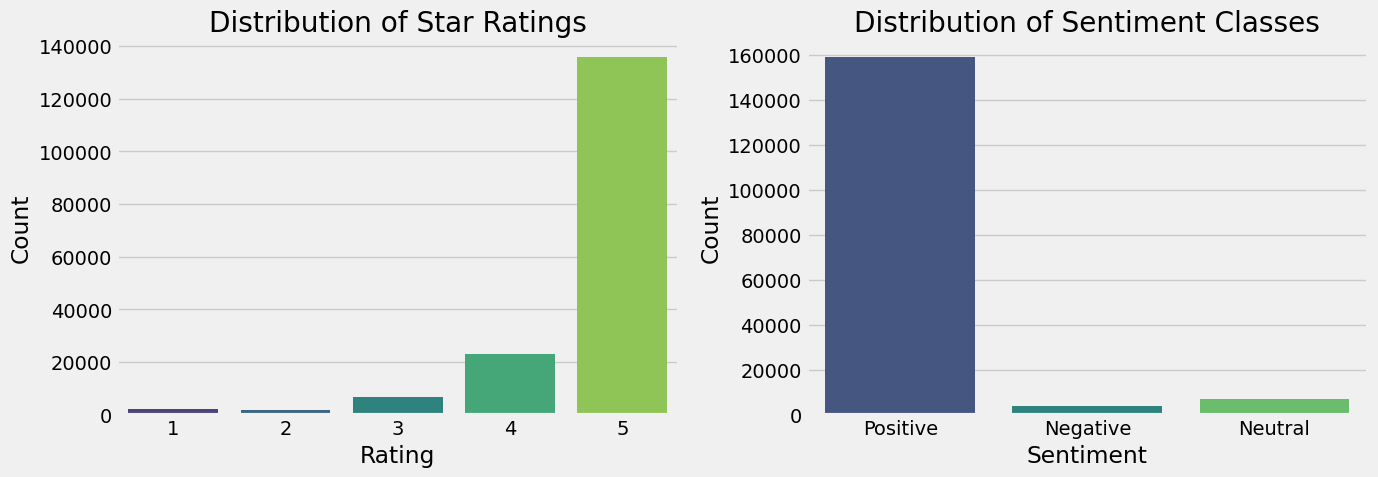


Sample reviews by sentiment:

Negative review (rated 1 stars):
The 2004 Grammy's voters proved what I have always thought....50 Cents is not talented!! For the first time (in a long time), the Grammy voters did the right by not giving an imposter an award. This cd sold hot, but it is not respected. 50 Cents even lost "Best New Artist" and had the nerve to get on stage to "protest". He only made himself look bad because no one saw his point (even his fellow rappers thought it was in bad taste). The worst offense to rap music this year is 50 Cents's "Get Rich Or Die Tryin" which is painfully dated. Gangsta rap died when 2Pac and Biggie died. Plus, this cd is not even "gangsta". Its corporate mindless rap, meant only to make money. I hope 50 realizes that his time is almost up.

Neutral review (rated 3 stars):
A piece danced to, during many late night benders with my Love. Lost to illness, the song brings back good memories of after work, late night dancing.

Positive review (rated 5 sta

In [47]:
# Plot the distribution of ratings and sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ratings distribution
sns.countplot(x='overall', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Star Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Sentiment distribution
sns.countplot(x='sentiment_label', data=df, palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Sentiment Classes')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Sample reviews by sentiment
print("\nSample reviews by sentiment:")
for sentiment in ['Negative', 'Neutral', 'Positive']:
    sample = df[df['sentiment_label'] == sentiment].sample(1).iloc[0]
    print(f"\n{sentiment} review (rated {sample['overall']} stars):")
    print(sample['reviewText'])


Performing undersampling to balance sentiment classes...
Minority class size (target size for each class): 4004

Undersampling complete.
New Balanced Sentiment Distribution:


,count
sentiment_label,
Negative,4004
Neutral,4004
Positive,4004


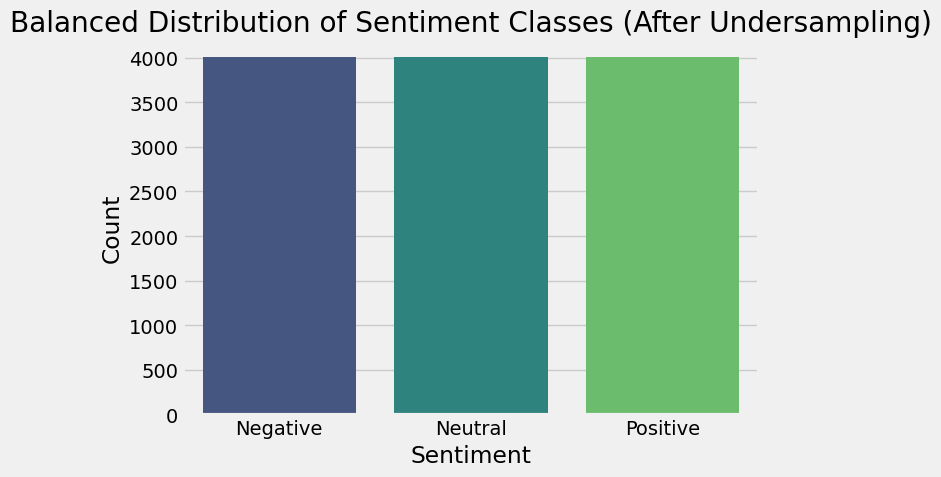

In [48]:
print("\nPerforming undersampling to balance sentiment classes...")

# Calculate value counts for each sentiment class
sentiment_counts = df['sentiment_label'].value_counts()

# Determine the size of the minority class
minority_class_size = sentiment_counts.min()
print(f"Minority class size (target size for each class): {minority_class_size}")

# Create a list to store the balanced dataframes
balanced_dfs = []

# Sample each class to the size of the minority class
for sentiment_label in sentiment_counts.index:
    # Get the subset of the dataframe for the current sentiment
    sentiment_subset = df[df['sentiment_label'] == sentiment_label]

    # Sample this subset down to the minority class size
    # Use random_state for reproducibility
    sampled_subset = sentiment_subset.sample(n=minority_class_size, random_state=42)

    balanced_dfs.append(sampled_subset)

# Concatenate the sampled dataframes into a single balanced dataframe
df_balanced = pd.concat(balanced_dfs)

# Shuffle the balanced dataframe (optional, but good practice)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nUndersampling complete.")
print("New Balanced Sentiment Distribution:")
display(df_balanced['sentiment_label'].value_counts())

# Visualize the balanced distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='sentiment_label', data=df_balanced, palette='viridis', order=['Negative', 'Neutral', 'Positive'])
plt.title('Balanced Distribution of Sentiment Classes (After Undersampling)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [49]:
df = df_balanced

In [50]:
# Text Preprocessing (Test for review text and summary)

def preprocess_text(text, remove_stopwords=True):
    """
    Preprocess the review text:
    - Convert to lowercase
    - Remove special characters and numbers
    - Remove extra whitespaces
    - Optionally remove stopwords

    Parameters:
    ----------
    text : str
        Text to preprocess
    remove_stopwords : bool
        Whether to remove stopwords

    Returns:
    -------
    str
        Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords (optional)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words]
        text = ' '.join(tokens)

    return text

# Apply preprocessing to review text
print("Preprocessing reviewText...")
df['processed_text'] = df['reviewText'].apply(lambda x: preprocess_text(x, remove_stopwords=False))
df['processed_text_no_stopwords'] = df['reviewText'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

# Display a sample review before and after preprocessing
sample_idx = np.random.randint(0, len(df))
print("\nSample review before preprocessing:")
print(df.iloc[sample_idx]['reviewText'])
print("\nAfter preprocessing (with stopwords):")
print(df.iloc[sample_idx]['processed_text'])
print("\nAfter preprocessing (without stopwords):")
print(df.iloc[sample_idx]['processed_text_no_stopwords'])

Preprocessing summary...

Sample review before preprocessing:
sorry,...

After preprocessing (with stopwords):
sorry

After preprocessing (without stopwords):
sorry


In [51]:
# Sentiment Analysis with Transformer Model

def analyze_sentiment_transformer(texts, batch_size=32):
    """
    Analyze sentiment using a pre-trained transformer model.

    Parameters:
    ----------
    texts : list
        List of texts to analyze
    batch_size : int
        Batch size for processing

    Returns:
    -------
    list
        List of sentiment scores (negative: 0, neutral: 1, positive: 2)
    """
    # Load pre-trained RoBERTa model for sentiment analysis
    # Make sure model and tokenizer are loaded using the intended device
    model_name = "cardiffnlp/twitter-roberta-base-sentiment"
    try:
        print(f"Loading tokenizer: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        print(f"Loading model: {model_name}")
        model = AutoModelForSequenceClassification.from_pretrained(model_name)

        # Explicitly move model to the correct device (GPU or CPU)
        model.to(device)
        print(f"Model moved to: {device}")

    except Exception as e:
        print(f"Error loading model/tokenizer: {e}")
        raise # Re-raise the exception to stop execution if loading fails

    # Create sentiment analysis pipeline
    print("Creating sentiment analysis pipeline...")
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1, # Use GPU if available
        truncation=True,  # <--- ADD THIS ARGUMENT
        # Optional: You could also explicitly set max_length,
        # but truncation=True usually defaults to the model's max length.
        # max_length=512 # Or 514 based on error, 512 is common for BERT/RoBERTa
        padding=True      # Add padding to make sequences in a batch the same length
    )
    print("Pipeline created successfully.")

    # Process texts in batches
    results = []
    print(f"Processing {len(texts)} texts in batches of {batch_size}...")
    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing Sentiment"):
        # Ensure the batch is a list of strings, handle potential None/NaN
        batch = [str(text) if pd.notna(text) else "" for text in texts[i:i+batch_size]]

        # Clear cache before processing batch (optional, might help with memory)
        clear_gpu_memory()

        try:
            outputs = sentiment_pipeline(batch)

            # Map labels to numeric values
            for output in outputs:
                if output['label'] == 'LABEL_0' or output['label'] == 'negative': # Handle potential variations in label names
                    results.append(0)
                elif output['label'] == 'LABEL_1' or output['label'] == 'neutral':
                    results.append(1)
                elif output['label'] == 'LABEL_2' or output['label'] == 'positive':
                    results.append(2)
                else:
                    print(f"Warning: Unexpected label '{output['label']}' encountered. Assigning neutral (1).")
                    results.append(1) # Assign neutral for unexpected labels

        except Exception as e:
            print(f"\nError processing batch starting at index {i}: {e}")
            print(f"Problematic batch content (first few items): {batch[:5]}")
            # Optionally add dummy results or skip batch
            results.extend([1] * len(batch)) # Add neutral sentiment for failed batch items
            clear_gpu_memory() # Attempt to clear memory after error

    print("Sentiment analysis complete.")
    return results

Analyzing sentiment for        overall  vote  verified   reviewTime      reviewerID        asin  \
0            1   NaN     False  09 17, 2015   A2YVQZKJYTAF7  B0159K08KC   
1            3   NaN      True  01 30, 2014   APVQY5E1BUEKA  B0011ZUMLK   
2            1   NaN     False  02 16, 2015  A36EDWL4F3AASU  B00137MSX6   
3            1   NaN      True  04 15, 2014  A3DG93E8TXMKZF  B001KOWH0G   
4            2   NaN      True  07 26, 2013   A3DLMVEC80G9P  B0011ZR5CO   
...        ...   ...       ...          ...             ...         ...   
12007        2   NaN      True  10 19, 2013  A3SGJJPVYRU2UA  B007YVUE8Q   
12008        3   NaN      True   06 3, 2016  A26SFT1QNKMLSL  B017JTOKV4   
12009        3   NaN      True  08 10, 2016  A1W05R5GVN8LTQ  B00122X5VG   
12010        5   4.0     False   06 9, 2015  A126C7MT8WWKG0  B00UFZYX08   
12011        3   NaN      True  02 11, 2016  A3HTWH15F39ZX1  B005G8WU4K   

                           style                           reviewerName  \


Device set to use cuda:0


Model moved to: cuda
Creating sentiment analysis pipeline...
Pipeline created successfully.
Processing 12012 texts in batches of 32...


Analyzing Sentiment:   0%|          | 0/376 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory cleared
GPU memory c

,Pred Negative,Pred Neutral,Pred Positive
True Negative,1553,2187,264
True Neutral,397,2733,874
True Positive,69,2428,1507



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.39      0.52      4004
           1       0.37      0.68      0.48      4004
           2       0.57      0.38      0.45      4004

    accuracy                           0.48     12012
   macro avg       0.57      0.48      0.48     12012
weighted avg       0.57      0.48      0.48     12012



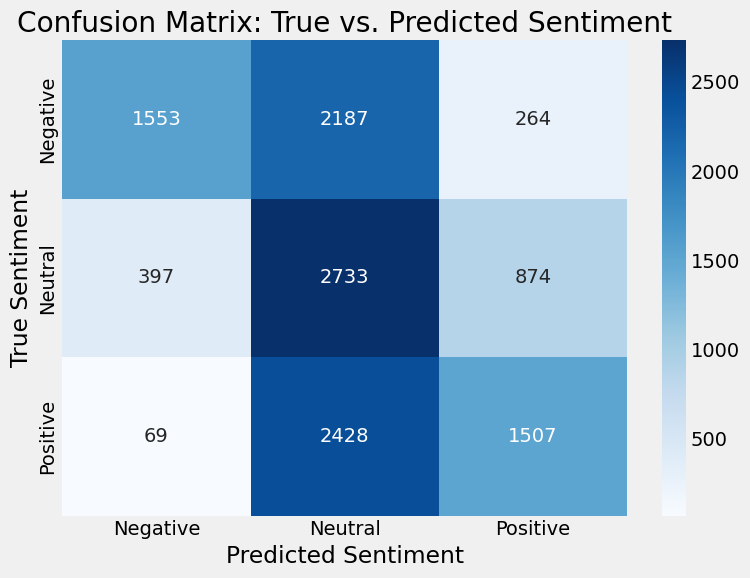

In [52]:
print(f"Analyzing sentiment for {df} reviews...")
# Analyze sentiment
predicted_sentiments = analyze_sentiment_transformer(df['processed_text'].tolist())
df['predicted_sentiment'] = predicted_sentiments
df['predicted_sentiment_label'] = df['predicted_sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

# Compare predicted sentiment with rating-based sentiment
conf_matrix = confusion_matrix(df['sentiment'], df['predicted_sentiment'])
class_report = classification_report(df['sentiment'], df['predicted_sentiment'])

print("\nConfusion Matrix:")
display(pd.DataFrame(
    conf_matrix,
    index=['True Negative', 'True Neutral', 'True Positive'],
    columns=['Pred Negative', 'Pred Neutral', 'Pred Positive']
))

print("\nClassification Report:")
print(class_report)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix: True vs. Predicted Sentiment')
plt.tight_layout()
plt.show()

In [23]:
# Analyze disagreements between rating-based and predicted sentiment
disagreements = df[df['sentiment'] != df['predicted_sentiment']]
print(f"\nNumber of disagreements: {len(disagreements)} ({len(disagreements)/len(df)*100:.2f}%)")

# Display a few examples of disagreements
if len(disagreements) > 0:
    print("\nExamples of disagreements:")
    for i, row in disagreements.head(3).iterrows():
        print(f"\nReview: {row['summary']}")
        print(f"Rating: {row['overall']} stars (interpreted as {row['sentiment_label']})")
        print(f"Model prediction: {row['predicted_sentiment_label']}")


Number of disagreements: 5810 (48.37%)

Examples of disagreements:

Review: Fight song is a way better song. Glad she didn't come out with this one first.
Rating: 1 stars (interpreted as Negative)
Model prediction: Positive

Review: No need to critique a "classic". If you know the artist, there's no complaint. If it's a digital purchase problem, so far AMAZON has great Customer Service.
Rating: 3 stars (interpreted as Neutral)
Model prediction: Positive

Review: IS IT POSSIBLE THAT THESE SONGS ARE STILL IN THE SYSTEM AND I CAN DOWNLOAD THEM AGAIN...I DID NOT RECEIVE ON MY IPOD.....
Rating: 2 stars (interpreted as Negative)
Model prediction: Neutral


In [24]:
# Topic Modeling with BERTopic

def extract_topics(texts, n_topics=10):
    """
    Extract topics from review texts using BERTopic.

    Parameters:
    ----------
    texts : list
        List of preprocessed texts
    n_topics : int
        Number of topics to extract

    Returns:
    -------
    BERTopic model
        Trained topic model
    list
        Topic assignments for each text
    """
    # Set up the vectorizer with proper parameters
    vectorizer = CountVectorizer(stop_words="english", min_df=5, max_df=0.95)

    # Initialize and train BERTopic model
    topic_model = BERTopic(
        nr_topics=n_topics,
        vectorizer_model=vectorizer,
        verbose=True
    )

    # Fit the model and transform documents to get topic assignments
    topics, _ = topic_model.fit_transform(texts)

    return topic_model, topics

# Extract topics from the preprocessed reviews
print("Extracting topics from reviews...")
topic_model, topic_assignments = extract_topics(df['processed_text'].tolist())

# Add topic assignments to the dataframe
df['topic'] = topic_assignments

# Get and display the top topics
top_topics = topic_model.get_topic_info().head(10)
print("\nTop topics:")
display(top_topics)

# Display top words for each topic
print("\nTop words for each topic:")
for topic_id in top_topics['Topic'].tolist():
    if topic_id == -1:
        print(f"Topic {topic_id}: Outlier topic")
        continue

    topic_words = topic_model.get_topic(topic_id)
    words = [word for word, _ in topic_words]
    print(f"Topic {topic_id}: {', '.join(words[:8])}")

# Visualize topics
topic_model.visualize_topics()

2025-05-04 18:20:13,246 - BERTopic - Embedding - Transforming documents to embeddings.


Extracting topics from reviews...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/376 [00:00<?, ?it/s]

2025-05-04 18:20:32,432 - BERTopic - Embedding - Completed ✓
2025-05-04 18:20:32,433 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-04 18:21:06,245 - BERTopic - Dimensionality - Completed ✓
2025-05-04 18:21:06,246 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-04 18:21:06,836 - BERTopic - Cluster - Completed ✓
2025-05-04 18:21:06,837 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-04 18:21:07,331 - BERTopic - Representation - Completed ✓
2025-05-04 18:21:07,332 - BERTopic - Topic reduction - Reducing number of topics
2025-05-04 18:21:07,361 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-04 18:21:07,764 - BERTopic - Representation - Completed ✓
2025-05-04 18:21:07,767 - BERTopic - Topic reduction - Reduced number of topics from 221 to 10



Top topics:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4103,-1_like_just_good_music,"[like, just, good, music, love, great, really,...",[there is no question about john legend he has...
1,0,5697,0_music_like_just_good,"[music, like, just, good, really, great, love,...",[jennifer is a great success story it seems ha...
2,1,1685,1_ok_good_love_great,"[ok, good, love, great, like, care, loved, did...","[ok, ok, ok]"
3,2,306,2_purchase_ordered_bought_didnt,"[purchase, ordered, bought, didnt, order, item...","[i didnt purchase this, i didnt purchase this,..."
4,3,71,3_credit_ordered_idea_order,"[credit, ordered, idea, order, purchased, use,...",[it downloaded twice i called for credit they ...
5,4,63,4_reason_recommend_played_play,"[reason, recommend, played, play, wont, bought...",[embedded drm prevents burning amazoncom downl...
6,5,29,5_write___,"[write, , , , , , , , , ]","[a, sample, write]"
7,6,28,6_review_im_going_fan,"[review, im, going, fan, doesnt, dont, called,...","[no review, no review, well im writing this re..."
8,7,16,7_gets_does_family_old,"[gets, does, family, old, theres, like, really...",[a total waste of two great acting talents jos...
9,8,14,8_used_loved_family_use,"[used, loved, family, use, purchased, bought, ...","[used for college classes, used this for a th ..."



Top words for each topic:
Topic -1: Outlier topic
Topic 0: music, like, just, good, really, great, love, better
Topic 1: ok, good, love, great, like, care, loved, didnt
Topic 2: purchase, ordered, bought, didnt, order, item, sorry, review
Topic 3: credit, ordered, idea, order, purchased, use, purchase, did
Topic 4: reason, recommend, played, play, wont, bought, work, try
Topic 5: write, , , , , , , 
Topic 6: review, im, going, fan, doesnt, dont, called, music
Topic 7: gets, does, family, old, theres, like, really, pretty
Topic 8: used, loved, family, use, purchased, bought, great, love


<Figure size 1400x800 with 0 Axes>

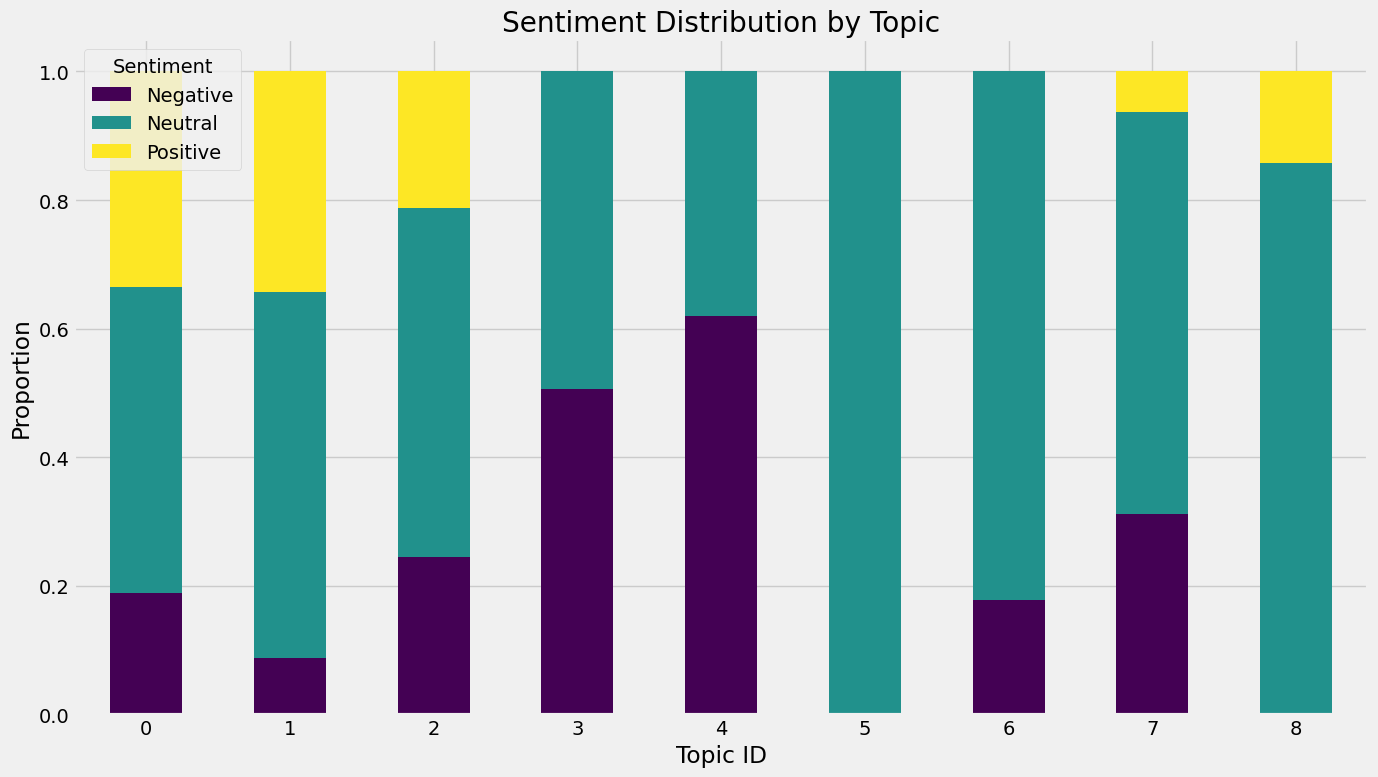

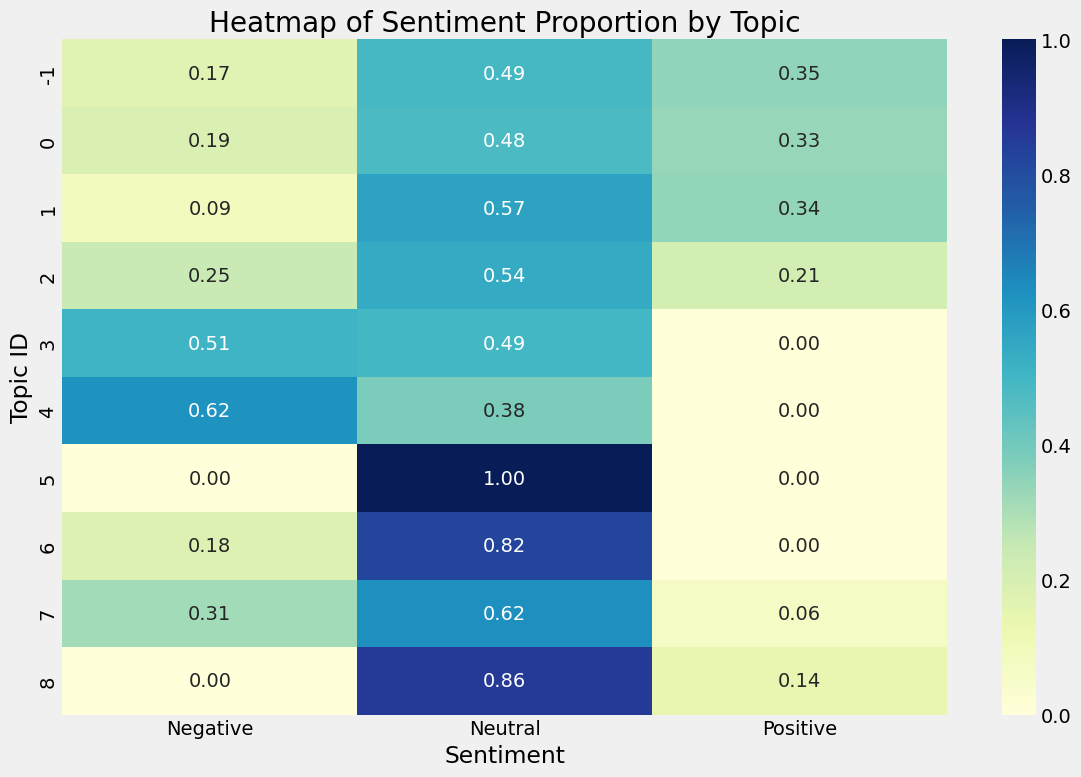


Topics ranked by sentiment (from most negative to most positive):
Topic 4 (reason, recommend, played, play, wont): 0.38 - Negative
Topic 3 (credit, ordered, idea, order, purchased): 0.49 - Negative
Topic 7 (gets, does, family, old, theres): 0.75 - Negative
Topic 6 (review, im, going, fan, doesnt): 0.82 - Negative
Topic 2 (purchase, ordered, bought, didnt, order): 0.97 - Negative
Topic 5 (write, , , , ): 1.00 - Neutral
Topic 8 (used, loved, family, use, purchased): 1.14 - Neutral
Topic 0 (music, like, just, good, really): 1.15 - Neutral
Topic 1 (ok, good, love, great, like): 1.26 - Neutral


In [25]:
# Cross-Analysis: Sentiment by Topic

# Count documents by topic and sentiment
topic_sentiment_counts = df.groupby(['topic', 'predicted_sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)

# Filter out the outlier topic (-1)
if -1 in topic_sentiment_props.index:
    topic_sentiment_filtered = topic_sentiment_props.drop(-1)
else:
    topic_sentiment_filtered = topic_sentiment_props

# Plot sentiment distribution by topic
plt.figure(figsize=(14, 8))
topic_sentiment_filtered.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8))
plt.title('Sentiment Distribution by Topic')
plt.xlabel('Topic ID')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Create a heatmap of sentiment by topic
sentiment_topic_pivot = pd.crosstab(
    df['topic'],
    df['predicted_sentiment_label'],
    normalize='index'
)

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_topic_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Heatmap of Sentiment Proportion by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic ID')
plt.tight_layout()
plt.show()

# Identify the most positive and negative topics
topic_sentiment_mean = df.groupby('topic')['predicted_sentiment'].mean().sort_values()
print("\nTopics ranked by sentiment (from most negative to most positive):")
for topic_id, sentiment_score in topic_sentiment_mean.items():
    if topic_id == -1:
        continue
    topic_words = ', '.join([word for word, _ in topic_model.get_topic(topic_id)][:5])
    sentiment_label = 'Negative' if sentiment_score < 1 else 'Neutral' if sentiment_score < 1.5 else 'Positive'
    print(f"Topic {topic_id} ({topic_words}): {sentiment_score:.2f} - {sentiment_label}")


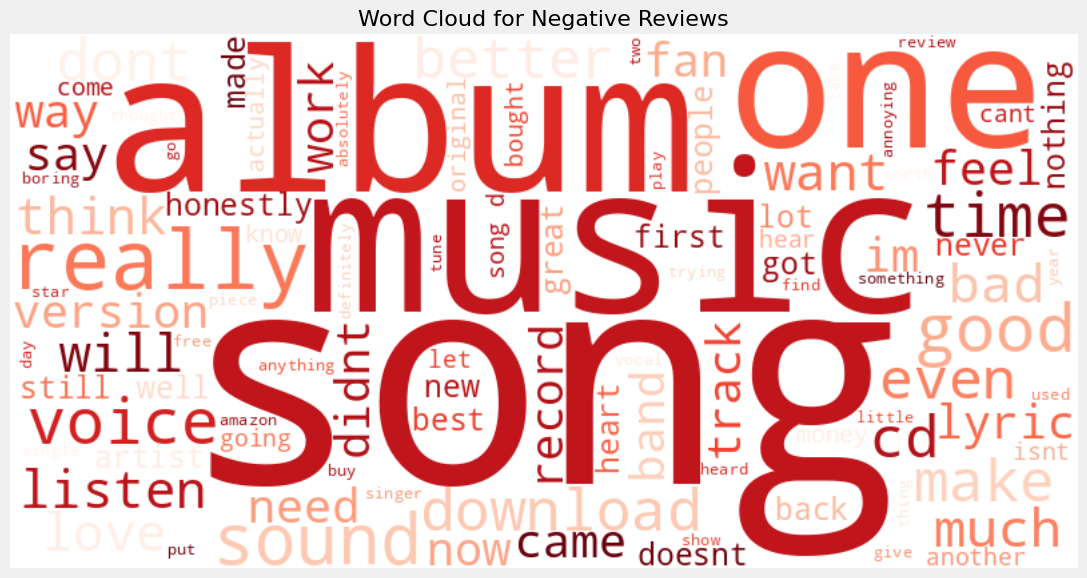

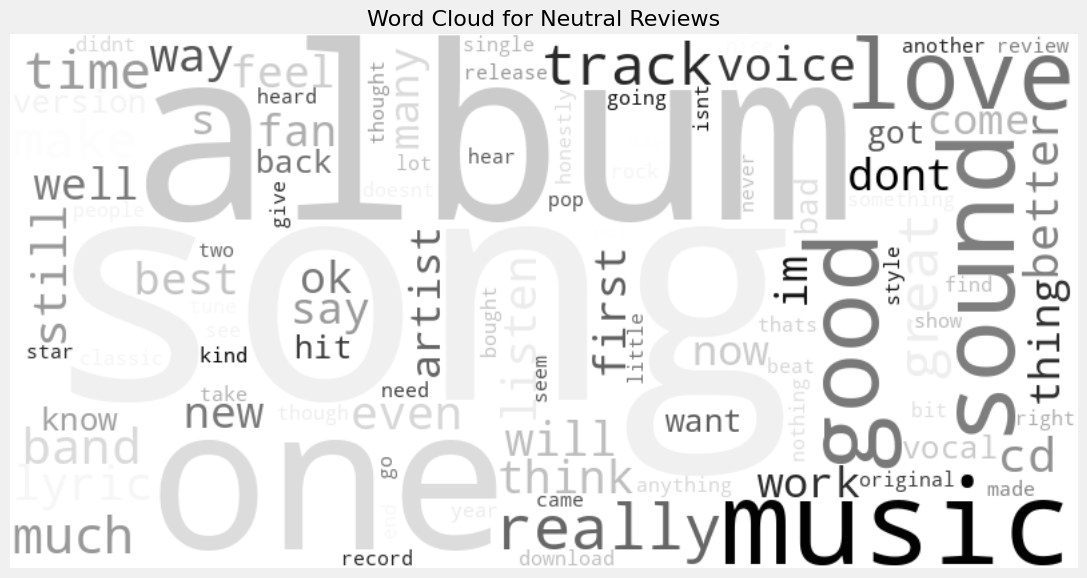

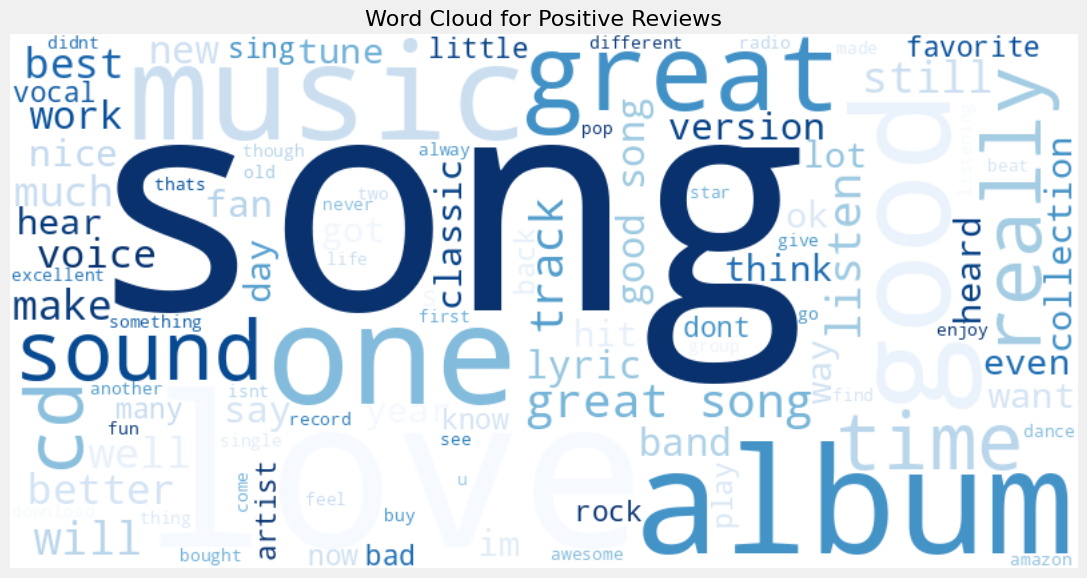

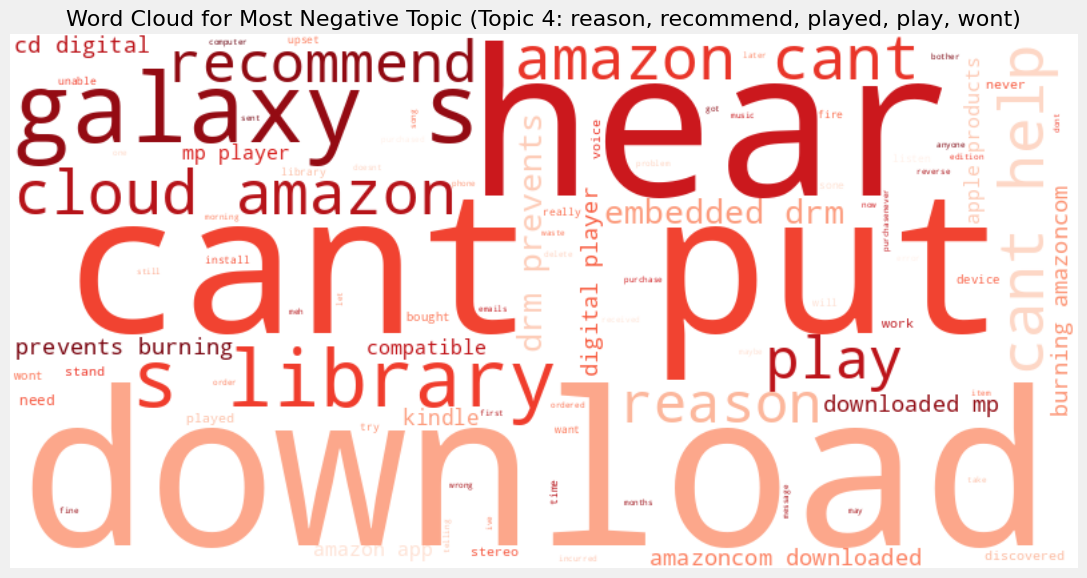

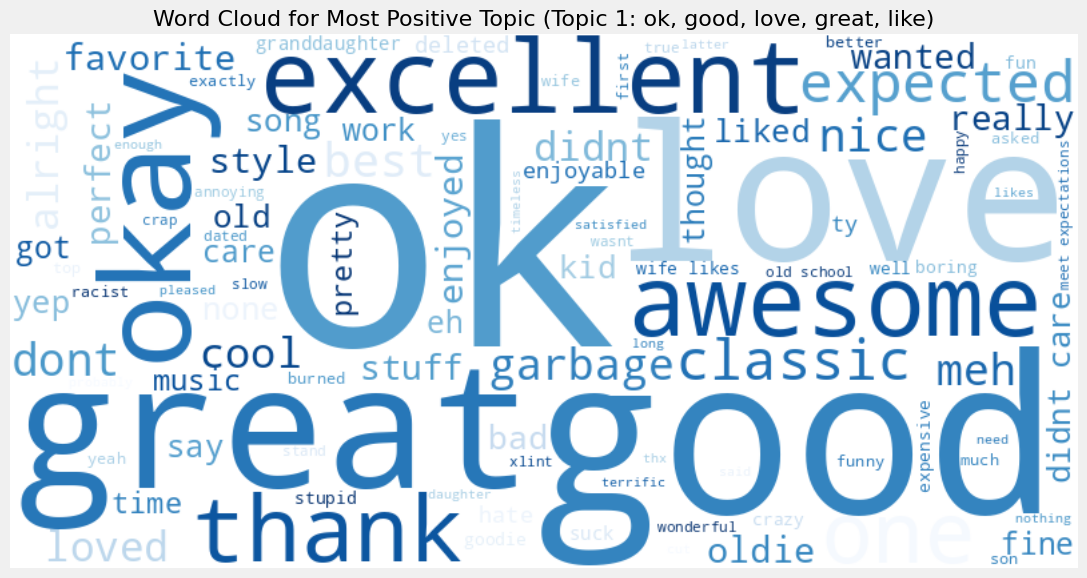

In [26]:
# Word Clouds by Sentiment and Topic

def generate_wordcloud(texts, title, colormap='viridis'):
    """
    Generate a word cloud visualization from a list of texts.

    Parameters:
    ----------
    texts : list
        List of texts to visualize
    title : str
        Title for the visualization
    colormap : str
        Matplotlib colormap name
    """
    # Combine all texts
    combined_text = ' '.join(texts)

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap,
        max_words=100,
        contour_width=3
    ).generate(combined_text)

    # Display the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate word clouds by sentiment
for sentiment_label in ['Negative', 'Neutral', 'Positive']:
    sentiment_texts = df[df['predicted_sentiment_label'] == sentiment_label]['processed_text'].tolist()
    if sentiment_texts:
        generate_wordcloud(
            sentiment_texts,
            f'Word Cloud for {sentiment_label} Reviews',
            colormap='Reds' if sentiment_label == 'Negative' else 'Blues' if sentiment_label == 'Positive' else 'Greys'
        )

# Generate word clouds for the most positive and negative topics
most_negative_topic = topic_sentiment_mean.index[0] if topic_sentiment_mean.index[0] != -1 else topic_sentiment_mean.index[1]
most_positive_topic = topic_sentiment_mean.index[-1] if topic_sentiment_mean.index[-1] != -1 else topic_sentiment_mean.index[-2]

for topic_id, sentiment_type in [(most_negative_topic, 'Negative'), (most_positive_topic, 'Positive')]:
    topic_texts = df[df['topic'] == topic_id]['processed_text'].tolist()
    if topic_texts:
        topic_words = ', '.join([word for word, _ in topic_model.get_topic(topic_id)][:5])
        generate_wordcloud(
            topic_texts,
            f'Word Cloud for Most {sentiment_type} Topic (Topic {topic_id}: {topic_words})',
            colormap='Reds' if sentiment_type == 'Negative' else 'Blues'
        )

In [28]:
# --- Replace your entire Plotly block with this ---

# Interactive Visualization with Plotly
print("\nGenerating interactive visualizations...")

# 1. Interactive Sentiment Distribution (Corrected)
print("Creating sentiment distribution bar chart...")
try:
    # Calculate value counts and reset index into a DataFrame
    sentiment_data_for_plot = df['predicted_sentiment_label'].value_counts().reset_index()

    # Dynamically get the actual column names
    if len(sentiment_data_for_plot.columns) == 2:
        label_col_name = sentiment_data_for_plot.columns[0]
        count_col_name = sentiment_data_for_plot.columns[1]

        print(f"Plotting sentiment distribution with: x='{label_col_name}', y='{count_col_name}'")

        fig_bar = px.bar(
            sentiment_data_for_plot,
            x=label_col_name,
            y=count_col_name,
            color=label_col_name,
            color_discrete_sequence=px.colors.qualitative.Set1,
            labels={label_col_name: 'Sentiment', count_col_name: 'Number of Reviews'},
            title='Interactive Sentiment Distribution'
        )
        fig_bar.show()
    else:
        print("Warning: Could not automatically determine columns for sentiment distribution plot. Skipping.")

except KeyError:
    print("Warning: 'predicted_sentiment_label' column not found. Skipping sentiment distribution plot.")
except Exception as e:
    print(f"An error occurred during sentiment distribution plot generation: {e}")


# 2. Interactive Topic-Sentiment Heatmap (With Check)
print("\nCreating topic-sentiment heatmap...")
try:
    # Check if required columns exist
    if 'topic' in df.columns and 'predicted_sentiment_label' in df.columns:
        topic_sent_df = pd.crosstab(
            df['topic'],
            df['predicted_sentiment_label']
        )

        # Check if the crosstab is empty before plotting
        if not topic_sent_df.empty:
            fig_heatmap = px.imshow(
                topic_sent_df,
                labels=dict(x="Sentiment", y="Topic", color="Count"),
                x=topic_sent_df.columns,
                y=topic_sent_df.index,
                color_continuous_scale='Viridis',
                title='Interactive Topic-Sentiment Heatmap'
            )
            fig_heatmap.show()
        else:
            print("Warning: Topic-Sentiment crosstab is empty (no overlapping data). Skipping heatmap.")
    else:
        print("Warning: 'topic' or 'predicted_sentiment_label' column missing. Skipping topic-sentiment heatmap.")

except Exception as e:
    print(f"An error occurred during topic-sentiment heatmap generation: {e}")


# 3. Sunburst Chart of Topics and Sentiments (With Check)
print("\nCreating sentiment-topic sunburst chart...")
try:
    # Check if required columns exist
    if 'topic' in df.columns and 'predicted_sentiment_label' in df.columns:
        # Create topic names (handle potential NaN topics if necessary)
        df_filtered_sunburst = df.dropna(subset=['topic', 'predicted_sentiment_label'])
        if not df_filtered_sunburst.empty:
            topic_names = {topic_id: f"Topic {int(topic_id)}" for topic_id in df_filtered_sunburst['topic'].unique()}
            df_filtered_sunburst['topic_name'] = df_filtered_sunburst['topic'].map(topic_names)

            fig_sunburst = px.sunburst(
                df_filtered_sunburst,
                path=['predicted_sentiment_label', 'topic_name'],
                title='Sunburst Chart: Sentiment → Topic',
                color_discrete_sequence=px.colors.qualitative.Bold
            )
            fig_sunburst.show()
        else:
             print("Warning: No valid data found for sunburst chart after filtering NaNs. Skipping.")
    else:
        print("Warning: 'topic' or 'predicted_sentiment_label' column missing. Skipping sunburst chart.")

except Exception as e:
    print(f"An error occurred during sunburst chart generation: {e}")

print("\nInteractive visualization generation complete.")


Generating interactive visualizations...
Creating sentiment distribution bar chart...
Plotting sentiment distribution with: x='predicted_sentiment_label', y='count'



Creating topic-sentiment heatmap...



Creating sentiment-topic sunburst chart...



Interactive visualization generation complete.


In [ ]:
def save_model(df, topic_model, file_name='sentiment_analysis_data.joblib'):
    """
    Save the necessary data and models for Streamlit deployment using joblib.
    Joblib is more efficient than pickle especially for objects that contain
    large numpy arrays, which is common in ML models.

    Parameters:
    ----------
    df : pd.DataFrame
        Processed dataframe
    topic_model : BERTopic
        Trained topic model
    file_name : str
        File name to save the data
    """
    import joblib

    # Create a dictionary with all necessary components
    project_data = {
        'sample_data': df,
        'topic_model': topic_model,
        'metadata': {
            'created_at': pd.Timestamp.now(),
            'sample_size': len(df),
            'top_topics': topic_model.get_topic_info().head(10).to_dict()
        }
    }

    # Save to file using joblib for better performance with scientific computing objects
    joblib.dump(project_data, file_name, compress=3)

    print(f"Data saved to {file_name} for Streamlit deployment using joblib")

# Save the necessary data for Streamlit deployment
save_model(df, topic_model)